In [1]:
#Installing the required packages

!pip install opencv-python matplotlib tensorflow


In [52]:
#Importing the necessary libraries

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import cv2
import imghdr
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, BatchNormalization, GlobalAveragePooling2D, Dense
from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall


from tensorflow.keras import Input
from tensorflow.keras.regularizers import l2

In [3]:
#Providing the dataset directory

data_dir = '/content/drive/MyDrive/AI Face Detection /Dataset/AI-face-detection-Dataset'

In [4]:
#Checking for dodgy images

extensions = ['jpg','jpeg','png','bmp']

for image_class in os.listdir(data_dir):
  class_dir = os.path.join(data_dir, image_class)

  for image_file in os.listdir(class_dir):
    image_path = os.path.join(class_dir, image_file)

    try:
      image = cv2.imread(image_path)
      file_type = imghdr.what(image_path)

      if file_type not in extensions:
        print('The image has an unsupported format')
        os.remove(image_path)

      elif image is None:
        print('Corrupt image. Removing', image_path)
        os.remove(image_path)

    except Exception as e:
      print(f'Error processing the file {image_path}:{e}')

There are no dodgy images

In [5]:
#Loading the dataset

dataset = tf.keras.utils.image_dataset_from_directory(data_dir)


Found 3233 files belonging to 2 classes.


In [6]:
#Viewing the numpy data in one batch

batch = dataset.as_numpy_iterator().next()
batch[0].shape

(32, 256, 256, 3)

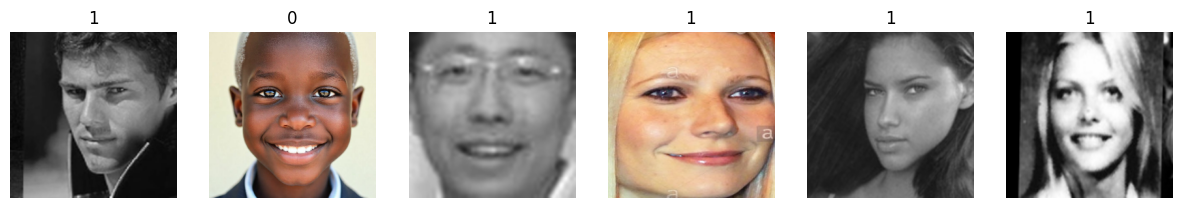

In [7]:
#Visualizing the images

fig, ax = plt.subplots(ncols = 6, figsize = (15,15))

for index, img in enumerate(batch[0][:6]):
  ax[index].imshow(img.astype(int))
  ax[index].title.set_text(batch[1][index])
  ax[index].axis('off')
plt.show()

*   0 - AI
*   1 - Real

In [8]:
#Resizing the images

dataset = dataset.map(lambda X, y : (X/255,y))

In [9]:
dataset.as_numpy_iterator().next()[0].min()

0.0

In [10]:
dataset.as_numpy_iterator().next()[0].max()

1.0

In [11]:
#Splitting the dataset

train_size = int(len(dataset) * 0.7)
val_size = int(len(dataset)* 0.2)
test_size = len(dataset) - train_size - val_size

print(train_size)
print(val_size)
print(test_size)

71
20
11


In [12]:
train = dataset.take(train_size)
val = dataset.skip(train_size).take(val_size)
test = dataset.skip(train_size + val_size).take(test_size)

print(len(train))
print(len(val))
print(len(test))

71
20
11


In [13]:
# Model Development

model = Sequential()

model.add(Input(shape=(256, 256, 3)))

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (5, 5), activation='relu', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (6, 6), activation='relu', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(GlobalAveragePooling2D())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01)))


In [14]:
#Compiling the model

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])


In [15]:
#Model Summary

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 254, 254, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 125, 125, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 58, 58, 64)          │         102,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 58, 58, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 29, 29, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 27, 27, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 27, 27, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 13, 13, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 8, 8, 128)           │         589,952 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 820,609 (3.13 MB)

 Trainable params: 819,777 (3.13 MB)

 Non-trainable params: 832 (3.25 KB)

In [16]:
#Fitting the model

from tensorflow.keras.callbacks import EarlyStopping

earlystopping = EarlyStopping(monitor = 'val_loss', patience = 10, restore_best_weights = True)

history = model.fit(train, validation_data=val, epochs = 20, callbacks = [earlystopping])

Epoch 1/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 41s 350ms/step - accuracy: 0.9487 - loss: 4.3572 - val_accuracy: 0.6891 - val_loss: 2.6439
Epoch 2/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 35s 447ms/step - accuracy: 0.9955 - loss: 1.4757 - val_accuracy: 0.6734 - val_loss: 1.9525
Epoch 3/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 26s 372ms/step - accuracy: 0.9949 - loss: 0.5695 - val_accuracy: 0.6750 - val_loss: 1.7950
Epoch 4/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 23s 324ms/step - accuracy: 0.9867 - loss: 0.3538 - val_accuracy: 0.6641 - val_loss: 1.5862
Epoch 5/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 50s 456ms/step - accuracy: 0.9885 - loss: 0.2204 - val_accuracy: 0.6812 - val_loss: 1.7093
Epoch 6/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 23s 330ms/step - accuracy: 0.9913 - loss: 0.1552 - val_accuracy: 0.7063 - val_loss: 1.8113
Epoch 7/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 22s 312ms/step - accuracy: 0.9934 - loss: 0.1413 - val_accuracy: 0.7000 - val_loss: 1.0890
Epoch 8/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 33s 462ms/step - accuracy: 0.9929 - loss: 0.1301 - val_accu

In [17]:
history.history

{'accuracy': [0.9784330725669861,
  0.9955986142158508,
  0.9911971688270569,
  0.9885563254356384,
  0.9911971688270569,
  0.9903169274330139,
  0.9925175905227661,
  0.9938380122184753,
  0.9933978915214539,
  0.9933978915214539,
  0.9916373491287231,
  0.9903169274330139,
  0.9938380122184753,
  0.9925175905227661,
  0.9929577708244324,
  0.9907570481300354,
  0.9938380122184753,
  0.9991196990013123,
  0.9938380122184753,
  0.9969190359115601],
 'loss': [3.453011989593506,
  1.1662007570266724,
  0.4904405176639557,
  0.309280127286911,
  0.18897777795791626,
  0.1554284691810608,
  0.1330677568912506,
  0.13330893218517303,
  0.11273243278265,
  0.1043182983994484,
  0.10074156522750854,
  0.12104086577892303,
  0.09399806708097458,
  0.08164141327142715,
  0.10261063277721405,
  0.09941006451845169,
  0.11382050812244415,
  0.07195741683244705,
  0.10052831470966339,
  0.0760233998298645],
 'val_accuracy': [0.6890624761581421,
  0.6734374761581421,
  0.675000011920929,
  0.664062

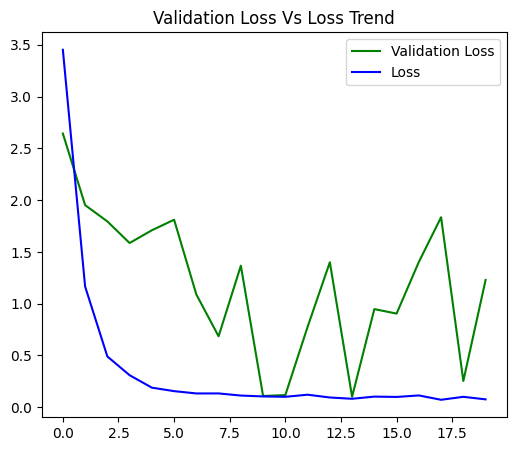

In [26]:
#Plotting the loss and validation loss scores

plt.figure(figsize = (6,5))
plt.plot(history.history['val_loss'], color = 'green', label = 'Validation Loss')
plt.plot(history.history['loss'], color = 'blue', label = 'Loss')
plt.legend(loc = 'best')
plt.title('Validation Loss Vs Loss Trend')
plt.show()

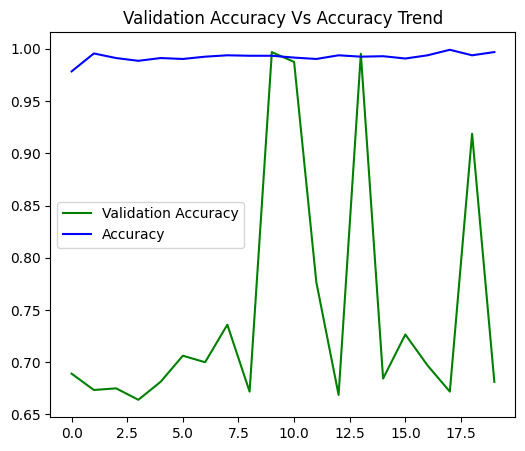

In [28]:
#Plotting the validation and accuracy scores

plt.figure(figsize = (6,5))
plt.plot(history.history['val_accuracy'], color = 'green', label = 'Validation Accuracy')
plt.plot(history.history['accuracy'], color = 'blue', label = 'Accuracy')
plt.legend(loc = 'best')
plt.title('Validation Accuracy Vs Accuracy Trend')
plt.show()

In [30]:
#Getting the accuracy of the model

re = Recall()
pre = Precision()
binary_acc = BinaryAccuracy()

for batch in test.as_numpy_iterator():
  X,y = batch
  y_predict = model.predict(X)
  re.update_state(y, y_predict)
  pre.update_state(y,y_predict)
  binary_acc.update_state(y,y_predict)

print('Recall:', re.result().numpy())
print('Precision:', pre.result().numpy())
print('Binary Accuracy:', binary_acc.result().numpy())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Recall: 0.99557525
Precision: 0.9911894
Binary Accuracy: 0.99065423


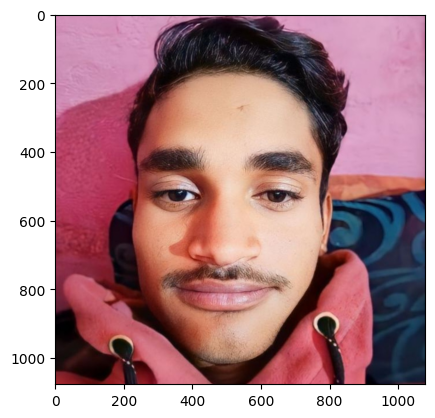

In [74]:
#Testing on new images
#Real image

dir = '/content/drive/MyDrive/AI Face Detection /Dataset/Test Data/real_test1.jpg'
real = cv2.imread(dir, cv2.IMREAD_COLOR)
real_rgb = cv2.cvtColor(real, cv2.COLOR_BGR2RGB)
plt.imshow(real_rgb)
plt.show()

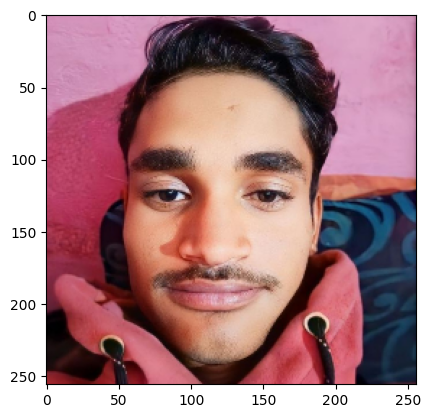

In [75]:
#Resizing the image

resize = tf.image.resize(real_rgb, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [76]:
#Making predictions

real_prediction = model.predict(np.expand_dims(resize/255, 0))
print(real_prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
[[0.96499056]]


The prediction is closer to 1 than 0, thus the image is classified as real.

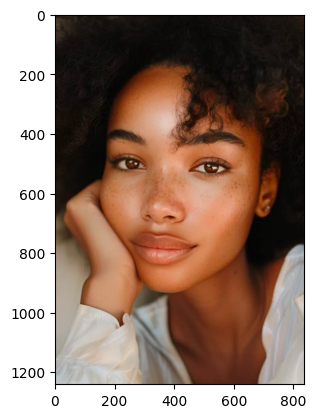

In [57]:
# AI Images

AI_dir = '/content/drive/MyDrive/AI Face Detection /Dataset/Test Data/AI_test.jpeg'
AI_test = cv2.imread(AI_dir, cv2.IMREAD_COLOR)
AI_rgb = cv2.cvtColor(AI_test, cv2.COLOR_BGR2RGB)
plt.imshow(AI_rgb)
plt.show()

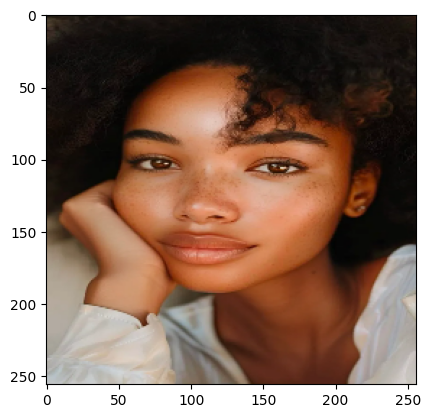

In [59]:
#Resizing the images

resize_AI = tf.image.resize(AI_rgb, (256,256))
plt.imshow(resize_AI.numpy().astype(int))
plt.show()

In [66]:
#Making predictions

AI_pred = model.predict(np.expand_dims(resize_AI/255, 0))
print(AI_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
[[0.17758633]]


The prediction is closer to 0 than 1, thus the image is classified as AI-generated.

In [77]:
#Saving the model

model_dir = '/content/drive/MyDrive/AI Face Detection /Model'
model.save(os.path.join(model_dir, 'AI_or_real_model.keras'))

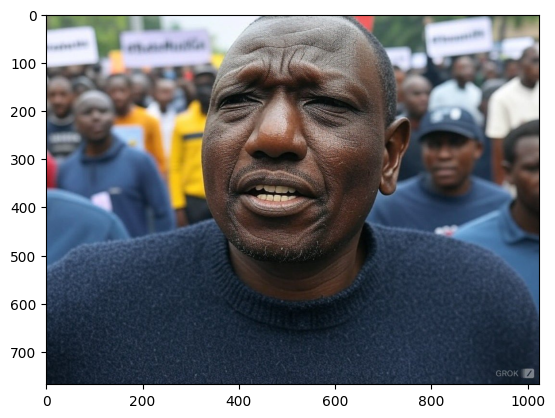

In [69]:
#Testing another AI Image

AI_test2_dir = '/content/drive/MyDrive/AI Face Detection /Dataset/Test Data/AI3_test.jpeg'

AI_test = cv2.imread(AI_test2_dir, cv2.IMREAD_COLOR)
AI_rgb = cv2.cvtColor(AI_test, cv2.COLOR_BGR2RGB)
plt.imshow(AI_rgb)
plt.show()

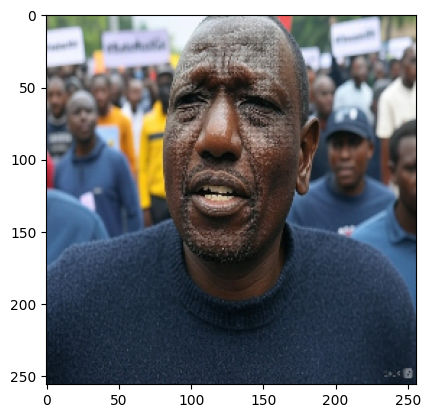

In [70]:
#Resizing the image

resize = tf.image.resize(AI_rgb, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [73]:
#Making predictions

AI_pred2 = model.predict(np.expand_dims(resize/255, 0))
print(AI_pred2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
[[0.06791566]]


The prediction is closer to 0 than 1, thus the image is classified as AI-generated.